# Image Alignment Tests
Our microscopy images drift signficiantly over time, which frustrates us being able to study how voids move between images.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rtdefects.drift import compute_drifts_from_images_multiref, compute_drift_from_image_pair
from skimage.transform import AffineTransform, warp
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve
from scipy.optimize import minimize
from functools import lru_cache
from imageio import v3 as iio
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

Configuration

In [2]:
run_directory = '../data/8bitTIFF-video24-550C/'

Initialize the output directory

In [3]:
run_directory = Path(run_directory)
out_directory = Path('output') / run_directory.name
out_directory.mkdir(exist_ok=True, parents=True)
(out_directory / 'figures').mkdir(exist_ok=True)

Make a cached function for reading images

In [4]:
imread_fun = lru_cache()(iio.imread)

## Get a list of images
We use the masks of void locations in the images as the FFT-based translation codes seem to work best with dealing with high-contrast images

In [5]:
images = sorted((run_directory / 'masks').glob('*tif'))
print(f'Found {len(images)} images')

Found 931 images


## Determine the correction
The idea is to determine drift by computing the [cross-correlation between the two images](https://en.wikipedia.org/wiki/Cross-correlation#/media/File:Cross_correlation_animation.gif). 
The largest peak in the cross-correlation will correspond to the translation that leads to the greatest overlap between the two images.
Due to same [math I don't understand](https://en.wikipedia.org/wiki/Discrete_Fourier_transform#Circular_convolution_theorem_and_cross-correlation_theorem), you can compute this cross-correlation very quickly using Fourier Transforms with [SciPy](https://stackoverflow.com/questions/24768222/how-to-detect-a-shift-between-images).

In [6]:
image_1 = imread_fun(images[0])
image_2 = imread_fun(images[4])

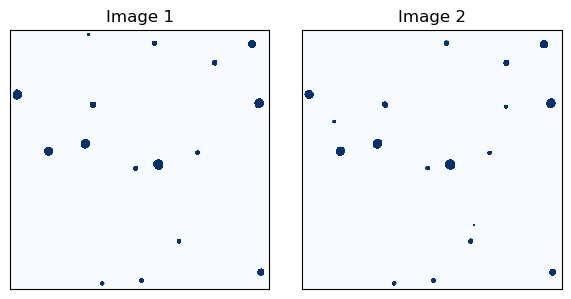

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3),)

for ax in axs:
    ax.set_yticks(ax.set_xticks([]))

# Plot the original and new overlapped
axs[0].imshow(image_1, cmap='Blues', vmin=0, vmax=1)
axs[0].set_title('Image 1')

# Plot the re-registered images
axs[1].imshow(image_2, cmap='Blues', vmin=0, vmax=1)
axs[1].set_title('Image 2')

fig.tight_layout()

It seems like image is drifting to the left and down.

In [8]:
drift, conv = compute_drift_from_image_pair(image_1, image_2, return_conv=True)
drift

array([-1,  0])

We can see the image drifted to the left (-x) and down (y)

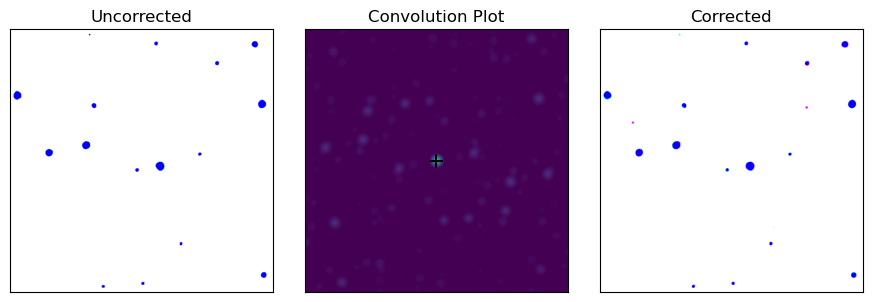

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3),)

for ax in axs:
    ax.set_yticks(ax.set_xticks([]))

# Plot the original and new overlapped
image = np.zeros((*image_1.shape, 3), dtype=np.uint8) + 255
image[:, :, 0] -= np.array((image_1 > 0) * 255, dtype=np.uint8)
image[:, :, 1] -= np.array((image_1 > 0) * 255, dtype=np.uint8)
axs[0].imshow(image)
axs[0].set_title('Uncorrected')

# Plot the convolution
axs[1].scatter([image_1.shape[0] // 2], [image_1.shape[1] // 2], marker='+', s=100., color='k')
axs[1].imshow(conv)
axs[1].set_title('Convolution Plot')

# Plot the re-registered images
affine = AffineTransform(translation=drift)
image_2_shift = np.array(warp(image_2, affine) * 255, dtype=np.uint8)
image = np.zeros((*image_1.shape, 3), dtype=np.uint8) + 255
image[:, :, 0] -= np.array((image_1 > 0) * 255, dtype=np.uint8)
image[:, :, 1] -= np.array((image_2_shift > 0) * 255, dtype=np.uint8)
axs[2].imshow(image)
axs[2].set_title('Corrected')

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-correlation.png', dpi=320)

The light and dark blue in the left image are the voids at different times. You can see the pattern drifts "up to the right" between them, which is reflected in the peak of the cross-correlation being up and to the right. 
Applying that transformation yields the two mapped directly atop each other.

## Apply to the whole stack
We can now compute the drift between successive images in the stack to get the total drift over time

In [10]:
stepwise_drifts = [
    compute_drift_from_image_pair(imread_fun(x), imread_fun(y))
    for x, y in tqdm(zip(images, images[1:]))
] 

930it [01:39,  9.38it/s]


Plot how the drift goes over time.

In [11]:
stepwise_drifts = np.vstack([[0, 0], stepwise_drifts])  # Initial frame has no drift

In [12]:
total_drift = np.cumsum(stepwise_drifts, axis=0)

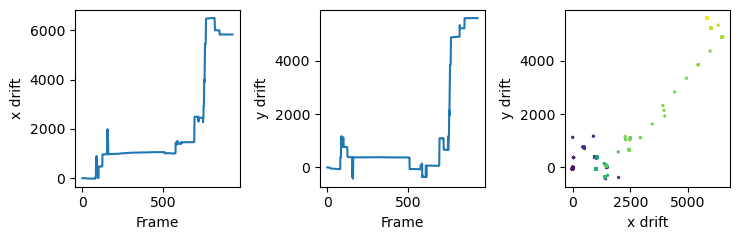

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5))

for ax, i, l in zip(axs, range(2), ['x', 'y']):
    ax.plot(total_drift[:, 1- i])
    ax.set_xlabel('Frame')
    ax.set_ylabel(l + ' drift')

axs[2].scatter(total_drift[:, 1], total_drift[:, 0], c=np.arange(total_drift.shape[0]), s=2)
axs[2].set_xlabel('x drift')
axs[2].set_ylabel('y drift')

# Plot the drifts
for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-from-fft.png', dpi=320)

This gives a quick estimate of drift by looking at individual pairs. One thing you will note are strong "jumps" between frames.

## Looking ahead multiple frames
The drift might be imperceptable between between adjacent frames but clearer for those far apart.
Judging image drift with frames several spaces apart will be able to give a better estimate, but at the expense of worse 

In [14]:
offsets = list(range(0, 20, 5))
drifts = [
    compute_drift_from_image_pair(image_1, imread_fun(images[i]))
    for i in tqdm(offsets)
]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


In [15]:
drifts = np.array(drifts)

Text(0, 0.5, 'Drifts')

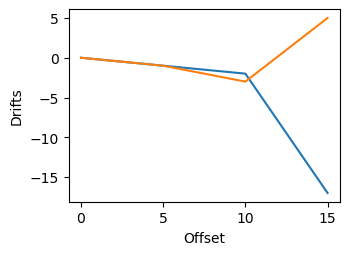

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(offsets, drifts[:, 0], label='x')
ax.plot(offsets, drifts[:, 1], label='y')

ax.set_xlabel('Offset')
ax.set_ylabel('Drifts')

The drift is probably nonlinear given that the drifts to not change linearly with offset. So, it is not likely that we can just assume the drift 1 step ahead is $1/N$ times the difference.

## Multi-Reference Point Drift Evaluation
Instead of relying on measuring the drift at each frame, we are going to fit a single function which explains the observed drift between many pairs of frames.
This will make it possible to include drifts computed between frames which are farther apart, where the estimates of drift are more accurate.

In [17]:
%%time
model_drift = compute_drifts_from_images_multiref([imread_fun(p) for p in images], offsets=(1, 4, 16, 32), pbar=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [06:45<00:00,  9.06it/s]

CPU times: user 4min 11s, sys: 2min 38s, total: 6min 49s
Wall time: 6min 46s


Make the drift such that the first frame has no drift

In [18]:
model_drift -= model_drift[0, :]

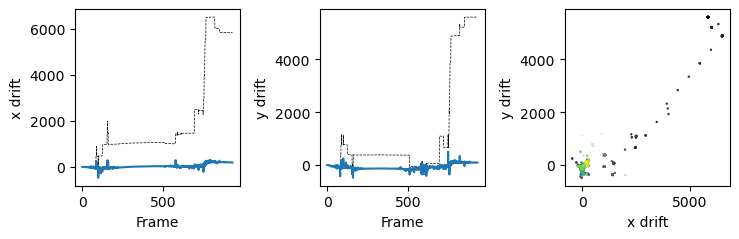

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5))

for ax, i, l in zip(axs, range(2), ['x', 'y']):
    ax.plot(total_drift[:, 1- i], 'k--', lw=0.5)
    ax.plot(model_drift[:, 1- i], '-')
    ax.set_xlabel('Frame')
    ax.set_ylabel(l + ' drift')

axs[2].scatter(total_drift[:, 1], total_drift[:, 0], c=np.arange(total_drift.shape[0]), s=0.5, cmap='gray_r')
axs[2].scatter(model_drift[:, 1], model_drift[:, 0], c=np.arange(total_drift.shape[0]), s=1)
axs[2].set_xlabel('x drift')
axs[2].set_ylabel('y drift')

# Plot the drifts
for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-from-fft-multi-refrence.png', dpi=320)

The drift seems to have a general trend but is more aggresive.

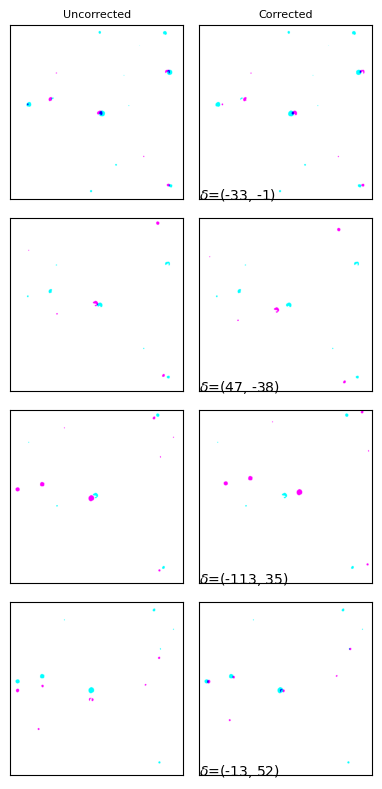

In [20]:
fig, axxs = plt.subplots(4, 2, figsize=(4, 8))


axxs[0, 0].set_title('Uncorrected', fontsize=8)
axxs[0, 1].set_title('Corrected', fontsize=8)

for axs, (ind_1, ind_2) in zip(axxs, [(30, 60), (60, 120), (120, 240), (240, 480)]):
    # Load the masks
    image_1 = imread_fun(images[ind_1])
    image_2 = imread_fun(images[ind_2])
    
    # Estimate the relative drift
    drift = model_drift[ind_2, :] - model_drift[ind_1, :]
    
    for ax in axs:
        ax.set_yticks(ax.set_xticks([]))

    # Plot the original and new overlapped
    image = np.zeros((*image_1.shape, 3), dtype=np.uint8) + 255
    image[:, :, 0] -= image_1
    image[:, :, 1] -= image_2
    axs[0].imshow(image)

    # Plot the re-registered images
    affine = AffineTransform(translation=drift)
    image_2_shift = np.array(warp(image_2, affine) * 255, dtype=np.uint8)
    image = np.zeros((*image_1.shape, 3), dtype=np.uint8) + 255
    image[:, :, 0] -= image_1
    image[:, :, 1] -= image_2_shift
    axs[1].imshow(image)
    axs[1].text(0, 0, f'$\delta$=({drift[0]:.0f}, {drift[1]:.0f})', transform=axs[1].transAxes)
    
    

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-correlation-multi-reference.png', dpi=320)

## Save Updated Model
Save it to disk for later use

In [21]:
out_path = out_directory / 'drifts-fft.csv'
pd.DataFrame(model_drift, columns=['x', 'y']).to_csv(out_path, index_label='frame')

## Update the Void Locations
The void locations in the defect details files with the run should be updated too.

In [22]:
defect_details = pd.read_json(run_directory / 'masks' / 'defect-details.json', lines=True).sort_values('image-path')

In [23]:
defect_details['positions_corrected-fft'] = [(x - y) if len(x) > 0 else x for x, y in zip(defect_details['positions'], model_drift)]
defect_details['drift'] = total_drift.tolist()

In [24]:
defect_details.to_json(out_directory / f'defect-details.json', orient='records', lines=True)